In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required libraries
!pip install transformers scikit-learn pandas torch peft umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.manifold import TSNE
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model
from torch.utils.data import DataLoader, Dataset


# Load LLM

In [4]:
# Load ClinicalT5 model
model_name = "Shijia/ClinicalT5-base-finetuned-biomedical"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/810 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

# Load File

In [5]:
# Load Pre-split Datasets
train_path = "/content/drive/MyDrive/P2/T1.2/Dataset/LLM-train.csv"
val_path = "/content/drive/MyDrive/P2/T1.2/Dataset/LLM-val.csv"
test_path = "/content/drive/MyDrive/P2/T1.2/Dataset/LLM-test.csv"

train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

In [6]:
# Encode Disease Labels
label_encoder = LabelEncoder()
train_data['disease_label'] = label_encoder.fit_transform(train_data['disease_label'])
val_data['disease_label'] = label_encoder.transform(val_data['disease_label'])
test_data['disease_label'] = label_encoder.transform(test_data['disease_label'])


# LoRA (Low-Rank Adaptation)

In [7]:
# Apply LoRA adaptation to ClinicalT5
lora_config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "encoder.block.0.layer.0.SelfAttention.q",
        "encoder.block.0.layer.0.SelfAttention.v",
        "encoder.block.1.layer.0.SelfAttention.q",
        "encoder.block.1.layer.0.SelfAttention.v",
        "encoder.block.2.layer.0.SelfAttention.q",
        "encoder.block.2.layer.0.SelfAttention.v",
        "decoder.block.0.layer.0.SelfAttention.q",
        "decoder.block.0.layer.0.SelfAttention.v",
        "decoder.block.1.layer.0.SelfAttention.q",
        "decoder.block.1.layer.0.SelfAttention.v",
        "decoder.block.2.layer.0.SelfAttention.q",
        "decoder.block.2.layer.0.SelfAttention.v"
    ],
    lora_dropout=0.2,
    task_type="SEQ_2_SEQ_LM"
)
model = get_peft_model(model, lora_config)
print("LoRA applied successfully!")

LoRA applied successfully!


In [8]:
# Tokenization function
def tokenize_texts(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")

# Tokenize dataset
train_encodings = tokenize_texts(train_data['symptoms'])
val_encodings = tokenize_texts(val_data['symptoms'])
train_labels_encodings = tokenize_texts(train_data['disease_label'].astype(str))
val_labels_encodings = tokenize_texts(val_data['disease_label'].astype(str))

# Dataset class
class SymptomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels_encodings):
        self.encodings = encodings
        self.labels_encodings = labels_encodings

    def __len__(self):
        return len(self.labels_encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels_encodings['input_ids'][idx]
        return item

train_dataset = SymptomDataset(train_encodings, train_labels_encodings)
val_dataset = SymptomDataset(val_encodings, val_labels_encodings)


# Fine-tuning ClinicalT5

In [11]:
# Fine-tuning ClinicalT5
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=128,
    num_train_epochs=6,
    weight_decay=0.01,
    gradient_accumulation_steps=4,
    save_strategy="epoch",
    save_total_limit=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,15.684100,0.406345
2,2.128300,0.156314
3,0.772500,0.099081
4,0.602600,0.075074
5,0.450900,0.060641
6,0.412500,0.057171


TrainOutput(global_step=4440, training_loss=2.486495421813415, metrics={'train_runtime': 2163.348, 'train_samples_per_second': 262.668, 'train_steps_per_second': 2.052, 'total_flos': 5.89739473862185e+16, 'train_loss': 2.486495421813415, 'epoch': 6.0})

# Generate ClinicalT5 Embedding for MLs

In [13]:
# Inference function
def predict_disease(symptoms):
    input_text = "predict disease: " + symptoms
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        output = model.generate(**inputs)
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Generate embeddings
def generate_t5_embeddings(data, column, batch_size=16):
    dataset = [text for text in data[column].tolist()]
    all_embeddings = []

    for i in range(0, len(dataset), batch_size):
        batch = dataset[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
        with torch.no_grad():
            encoder_outputs = model.encoder(**inputs)
            embeddings = encoder_outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            all_embeddings.extend(embeddings)

    return np.array(all_embeddings)

train_embeddings = generate_t5_embeddings(train_data, "symptoms")
val_embeddings = generate_t5_embeddings(val_data, "symptoms")
test_embeddings = generate_t5_embeddings(test_data, "symptoms")

# Apply PCA before ML classification
pca = PCA(n_components=50)
train_embeddings_pca = pca.fit_transform(train_embeddings)
val_embeddings_pca = pca.transform(val_embeddings)
test_embeddings_pca = pca.transform(test_embeddings)


# UMAP (Uniform Manifold Approximation and Projection)



Reducing dimensions using UMAP...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


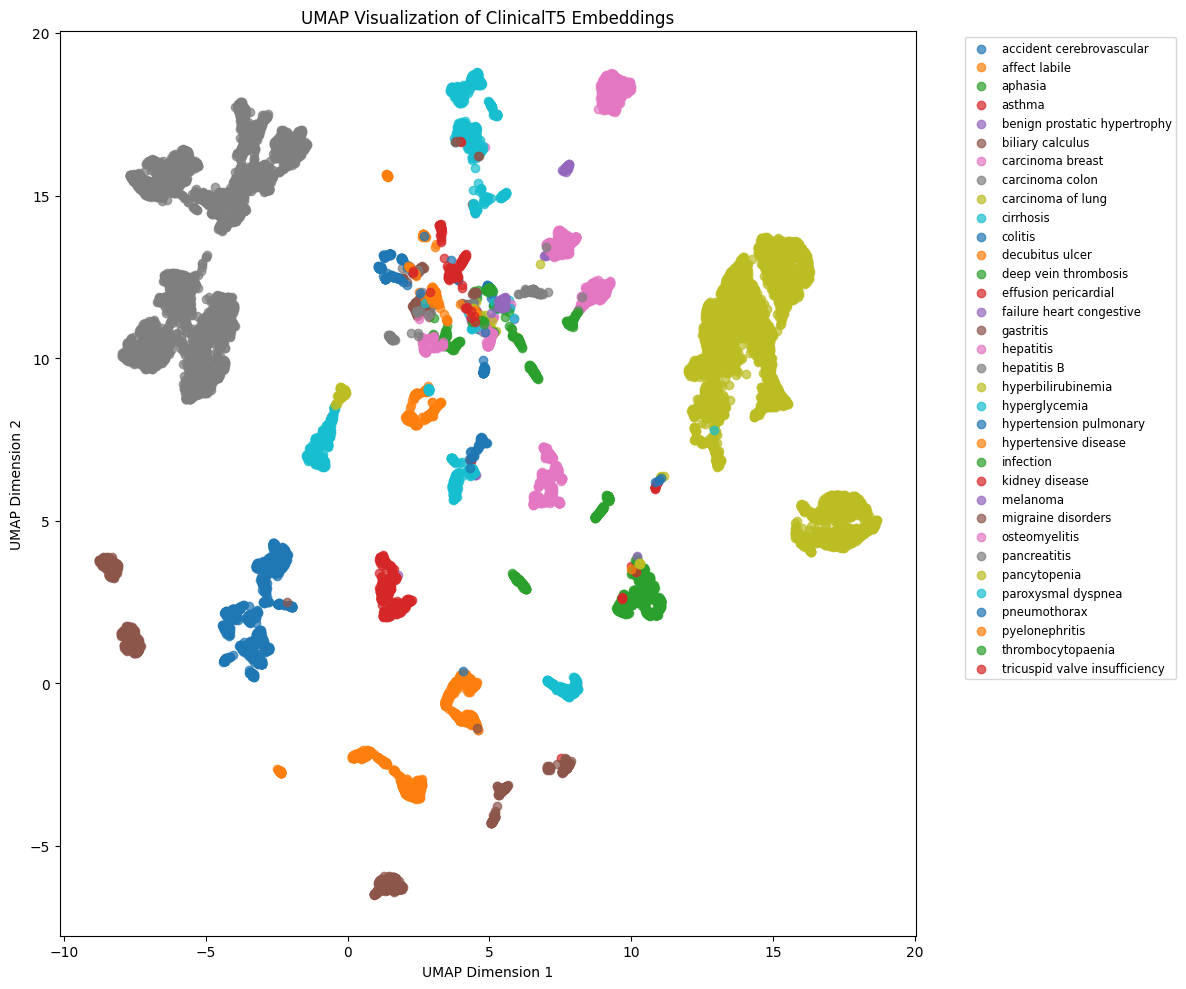

In [14]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np

# Generate test embeddings (ensure this is executed before using UMAP)
# test_embeddings should already be generated using your generate_embeddings function.
test_labels = torch.tensor(test_data['disease_label'].values, device=device)

# Convert test labels to NumPy for easier handling
labels = test_labels.cpu().numpy()  # Ensure this is defined and matches the test dataset

# Reduce dimensions using UMAP
print("Reducing dimensions using UMAP...")
umap_model = umap.UMAP(n_components=2, random_state=42)
reduced_embeddings = umap_model.fit_transform(test_embeddings)

# Map numeric labels to disease names
disease_names = label_encoder.inverse_transform(labels)  # Map numeric labels to actual disease names

# Plot the 2D representation
plt.figure(figsize=(12, 10))
unique_labels = np.unique(disease_names)

for disease in unique_labels:
    indices = np.where(disease_names == disease)
    plt.scatter(
        reduced_embeddings[indices, 0], reduced_embeddings[indices, 1],
        label=disease, alpha=0.7
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.title("UMAP Visualization of ClinicalT5 Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.tight_layout()
plt.show()


# Naive Bayes

In [15]:
# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(train_embeddings, train_data['disease_label']) # Change 'encoded_labels' to 'disease_label'

# Validate the Model
val_preds = nb_model.predict(val_embeddings)
val_report = classification_report(val_data['disease_label'], val_preds, target_names=label_encoder.classes_, output_dict=True) # Change val_labels to val_data['disease_label']
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = nb_model.predict(test_embeddings)
test_report = classification_report(test_data['disease_label'], test_preds, target_names=label_encoder.classes_, output_dict=True) # Change test_labels to test_data['disease_label']
print("Test Report:")
print(pd.DataFrame(test_report))

Validation Report:
           accident cerebrovascular  affect labile    aphasia     asthma  \
precision                  1.000000       0.897436   0.297521   0.635514   
recall                     0.815789       0.921053   0.947368   0.894737   
f1-score                   0.898551       0.909091   0.452830   0.743169   
support                   38.000000      76.000000  38.000000  76.000000   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                      0.209632          0.984791          1.000000   
recall                         0.973684          0.843648          0.941368   
f1-score                       0.344988          0.908772          0.969799   
support                       76.000000        614.000000        614.000000   

           carcinoma colon  carcinoma of lung   cirrhosis  ...  pancreatitis  \
precision         1.000000           1.000000    0.998255  ...      0.272727   
recall            0.979247           0.94323

In [16]:
# Save Classification Report to CSV
test_report_df = pd.DataFrame(test_report).transpose()
test_report_path = "/content/drive/MyDrive/P2/T1.2/Dataset/LLM + ML/clinicalT5-nb-class.csv"
test_report_df.to_csv(test_report_path, index=True)
print(f"Classification report saved to {test_report_path}")

Classification report saved to /content/drive/MyDrive/P2/T1.2/Dataset/LLM + ML/clinicalT5-nb-class.csv


In [17]:
# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(train_embeddings, train_data['disease_label']) # Changed 'encoded_labels' to 'disease_label'

# Validate the Model
val_preds = nb_model.predict(val_embeddings)
val_report = classification_report(val_data['disease_label'], val_preds, target_names=label_encoder.classes_, output_dict=True) # Change val_labels to val_data['disease_label']
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = nb_model.predict(test_embeddings)
test_report = classification_report(test_data['disease_label'], test_preds, target_names=label_encoder.classes_, output_dict=True) # Change test_labels to test_data['disease_label']
print("Test Report:")
print(pd.DataFrame(test_report))

Validation Report:
           accident cerebrovascular  affect labile    aphasia     asthma  \
precision                  1.000000       0.897436   0.297521   0.635514   
recall                     0.815789       0.921053   0.947368   0.894737   
f1-score                   0.898551       0.909091   0.452830   0.743169   
support                   38.000000      76.000000  38.000000  76.000000   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                      0.209632          0.984791          1.000000   
recall                         0.973684          0.843648          0.941368   
f1-score                       0.344988          0.908772          0.969799   
support                       76.000000        614.000000        614.000000   

           carcinoma colon  carcinoma of lung   cirrhosis  ...  pancreatitis  \
precision         1.000000           1.000000    0.998255  ...      0.272727   
recall            0.979247           0.94323

Validation Report:
           accident cerebrovascular  affect labile    aphasia     asthma  \
precision                  1.000000       0.897436   0.297521   0.635514   
recall                     0.815789       0.921053   0.947368   0.894737   
f1-score                   0.898551       0.909091   0.452830   0.743169   
support                   38.000000      76.000000  38.000000  76.000000   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                      0.209632          0.984791          1.000000   
recall                         0.973684          0.843648          0.941368   
f1-score                       0.344988          0.908772          0.969799   
support                       76.000000        614.000000        614.000000   

           carcinoma colon  carcinoma of lung   cirrhosis  ...  pancreatitis  \
precision         1.000000           1.000000    0.998255  ...      0.272727   
recall            0.979247           0.94323

<Figure size 1800x800 with 0 Axes>

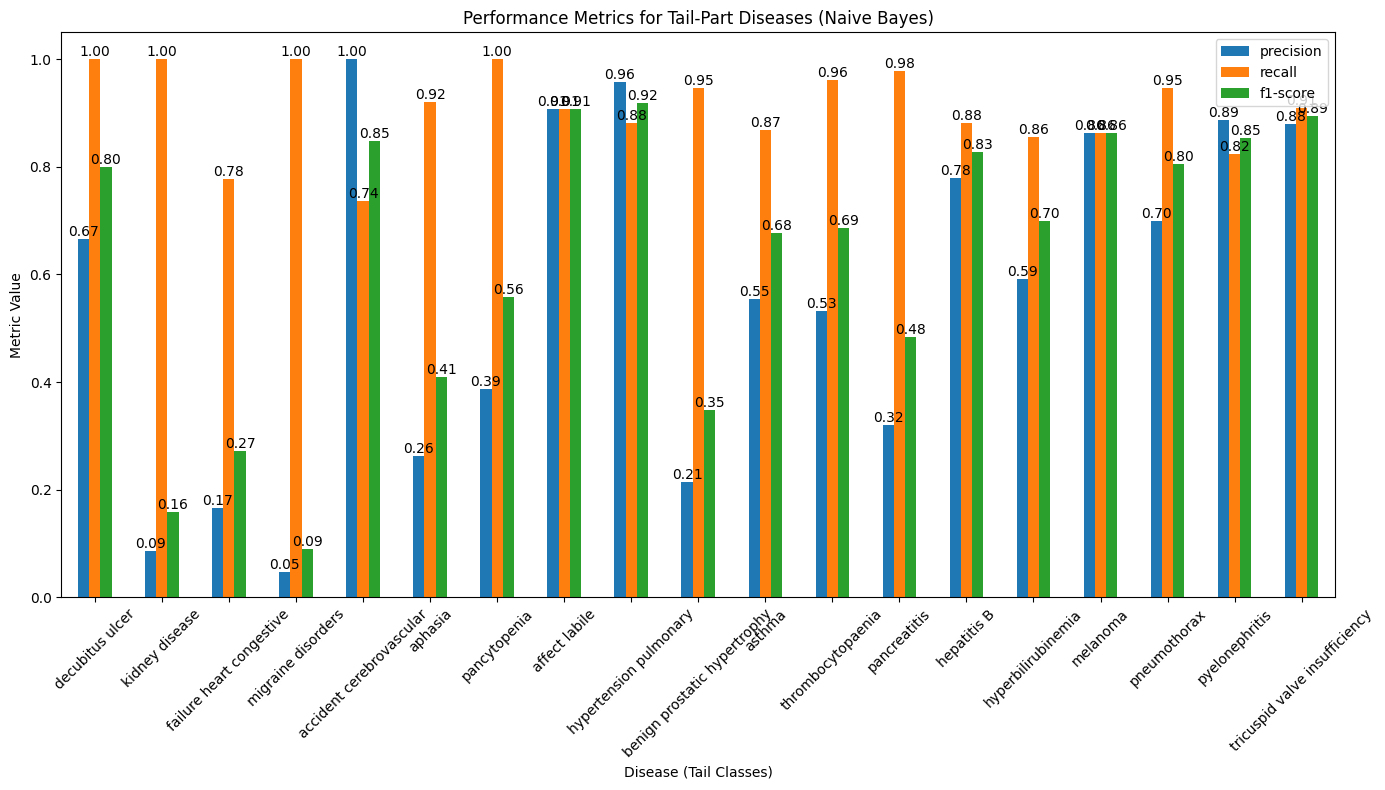

In [18]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(train_embeddings, train_data['disease_label']) # Changed 'encoded_labels' to 'disease_label'

# Validate the Model
val_preds = nb_model.predict(val_embeddings)
val_report = classification_report(val_data['disease_label'], val_preds, target_names=label_encoder.classes_, output_dict=True) # Change val_labels to val_data['disease_label']
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = nb_model.predict(test_embeddings)
test_report = classification_report(test_data['disease_label'], test_preds, target_names=label_encoder.classes_, output_dict=True) # Change test_labels to test_data['disease_label']
print("Test Report:")
print(pd.DataFrame(test_report))

# Generate Classification Report for Tail-Part Diseases
tail_part_diseases = [
    "decubitus ulcer", "kidney disease", "failure heart congestive", "migraine disorders", "accident cerebrovascular",
    "aphasia", "pancytopenia", "affect labile", "hypertension pulmonary", "benign prostatic hypertrophy",
    "asthma", "thrombocytopaenia", "pancreatitis", "hepatitis B", "hyperbilirubinemia",
    "melanoma", "pneumothorax", "pyelonephritis", "tricuspid valve insufficiency"
]

# Convert classification report to DataFrame
test_report_df = pd.DataFrame(test_report).transpose()

# Ensure only existing diseases are considered
tail_part_diseases_present = [disease for disease in tail_part_diseases if disease in test_report_df.index]

# Extract metrics for the diseases in the tail_part_diseases list
tail_metrics = test_report_df.loc[tail_part_diseases_present, ["precision", "recall", "f1-score"]]

# Plot the metrics for tail-part diseases
plt.figure(figsize=(18, 8))
ax = tail_metrics.plot(kind='bar', figsize=(14, 8), legend=True)

# Annotate values on the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

# Add titles and labels
plt.title("Performance Metrics for Tail-Part Diseases (Naive Bayes)")
plt.xlabel("Disease (Tail Classes)")
plt.ylabel("Metric Value")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


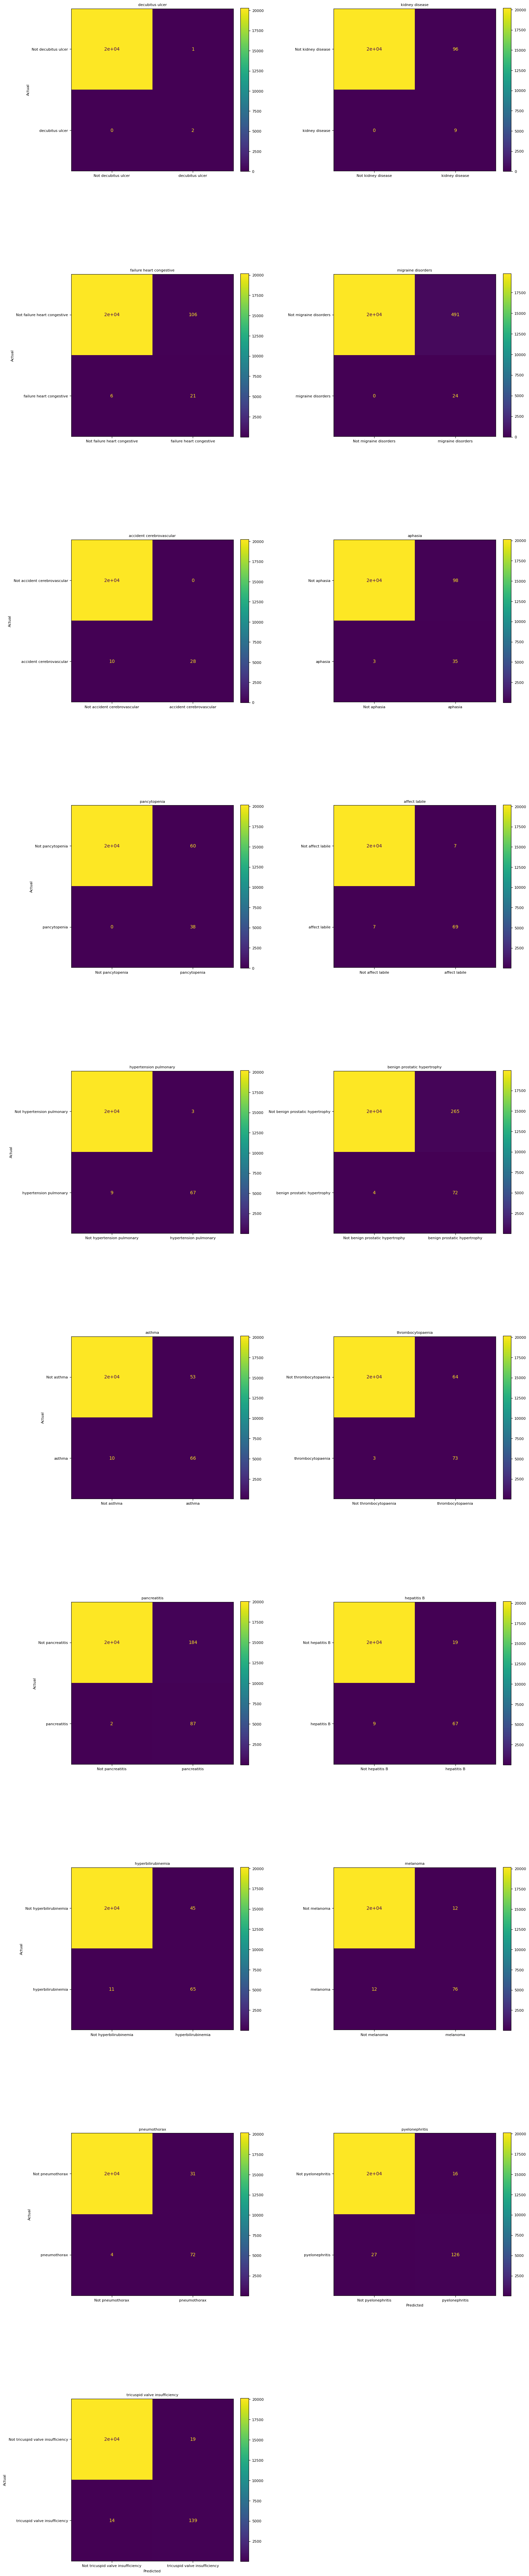

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the tail-part diseases
tail_part_diseases = [
    "decubitus ulcer", "kidney disease", "failure heart congestive", "migraine disorders", "accident cerebrovascular",
    "aphasia", "pancytopenia", "affect labile", "hypertension pulmonary", "benign prostatic hypertrophy",
    "asthma", "thrombocytopaenia", "pancreatitis", "hepatitis B", "hyperbilirubinemia",
    "melanoma", "pneumothorax", "pyelonephritis", "tricuspid valve insufficiency"
]

# Ensure only existing diseases are considered
tail_part_diseases_present = [disease for disease in tail_part_diseases if disease in label_encoder.classes_]

# Plot settings
num_plots_per_row = 2
plot_size = (8, 8)

plt.figure(figsize=(plot_size[0] * num_plots_per_row, plot_size[1] * ((len(tail_part_diseases_present) + num_plots_per_row - 1) // num_plots_per_row)))

for i, disease in enumerate(tail_part_diseases_present):
    # Get the disease index
    disease_idx = list(label_encoder.classes_).index(disease)

    # Convert test_labels to NumPy array and create binary labels
    y_test_binary = (test_labels.cpu().numpy() == disease_idx).astype(int)
    y_pred_binary = (test_preds == disease_idx).astype(int)  # Assuming test_preds is already a NumPy array

    # Compute the confusion matrix
    cm = confusion_matrix(y_test_binary, y_pred_binary, labels=[0, 1])

    # Plot the confusion matrix
    ax = plt.subplot((len(tail_part_diseases_present) + num_plots_per_row - 1) // num_plots_per_row, num_plots_per_row, i + 1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not " + disease, disease])
    disp.plot(cmap='viridis', xticks_rotation='horizontal', ax=ax, colorbar=False)
    cbar = plt.colorbar(disp.im_, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)
    ax.set_title(f"{disease}", fontsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xlabel("Predicted", fontsize=8)
    ax.set_ylabel("Actual", fontsize=8)
    if i % num_plots_per_row != 0:
        ax.set_ylabel('')
    if i < len(tail_part_diseases_present) - num_plots_per_row:
        ax.set_xlabel('')

plt.tight_layout()
plt.show()


# Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest on Embeddings
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_embeddings, train_data['disease_label'])

# Validate the Model
val_preds = rf_model.predict(val_embeddings)
val_report = classification_report(val_data['disease_label'], val_preds, target_names=label_encoder.classes_, output_dict=True) # Make sure val_labels is defined and contains the validation labels
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = rf_model.predict(test_embeddings)
test_report = classification_report(test_data['disease_label'], test_preds, target_names=label_encoder.classes_, output_dict=True) # Make sure test_labels is defined and contains the test labels
print("Test Report:")
print(pd.DataFrame(test_report))


Validation Report:
           accident cerebrovascular  affect labile    aphasia     asthma  \
precision                  1.000000       1.000000   1.000000   0.972603   
recall                     0.947368       0.934211   0.736842   0.934211   
f1-score                   0.972973       0.965986   0.848485   0.953020   
support                   38.000000      76.000000  38.000000  76.000000   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                      0.961538          0.963025          1.000000   
recall                         0.986842          0.933225          0.982085   
f1-score                       0.974026          0.947891          0.990961   
support                       76.000000        614.000000        614.000000   

           carcinoma colon  carcinoma of lung   cirrhosis  ...  pancreatitis  \
precision         0.995943           0.998576    0.983819  ...      0.629630   
recall            0.998983           0.99877

In [27]:
# Save Classification Report to CSV
test_report_df = pd.DataFrame(test_report).transpose()
test_report_path = "/content/drive/MyDrive/P2/T1.2/Dataset/LLM + ML/clinicalT5-rf-class.csv"
test_report_df.to_csv(test_report_path, index=True)
print(f"Classification report saved to {test_report_path}")

Classification report saved to /content/drive/MyDrive/P2/T1.2/Dataset/LLM + ML/clinicalT5-rf-class.csv


<Figure size 1800x800 with 0 Axes>

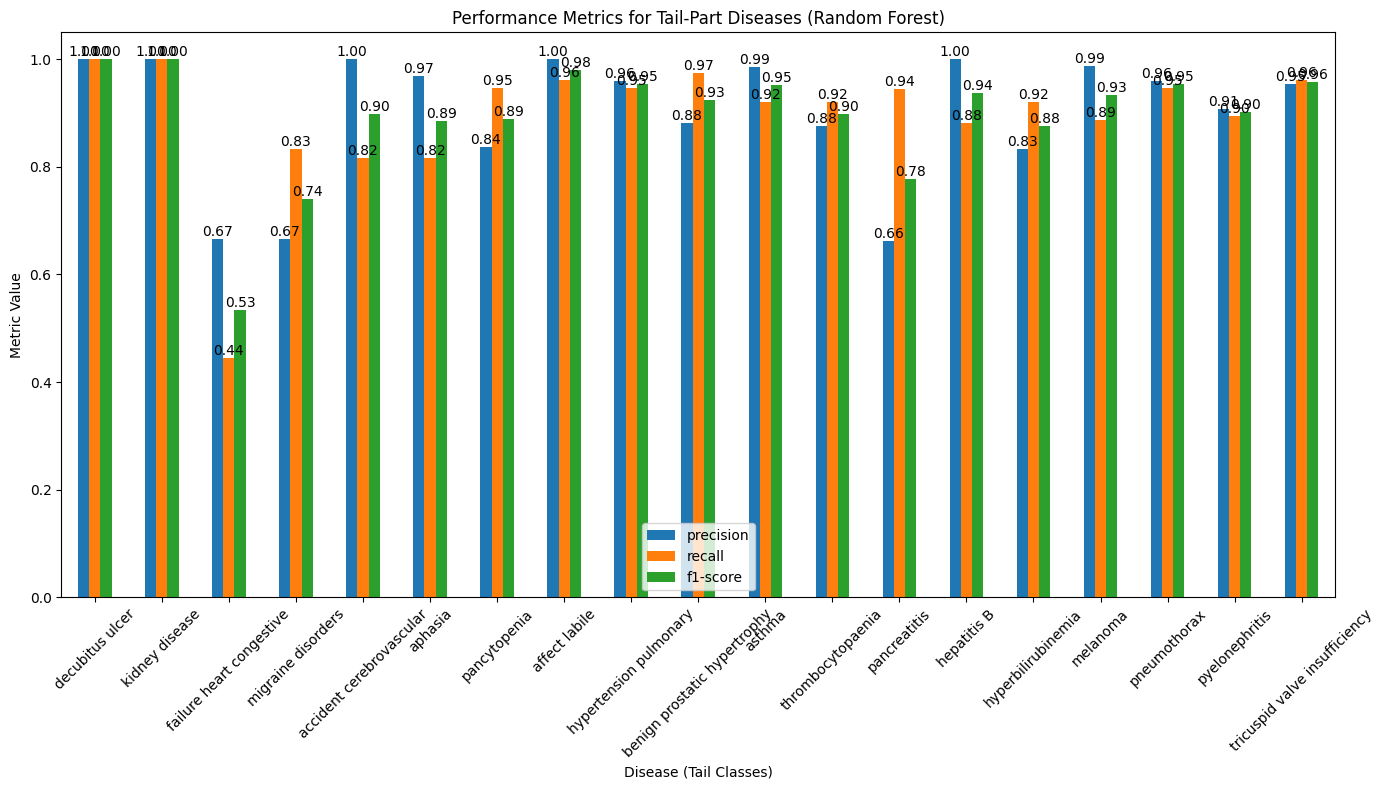

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Generate the classification report for test predictions
# `test_labels` and `test_preds` should come from your LLM + ML code
report_dict = classification_report(
    test_labels.cpu().numpy(),  # Convert PyTorch tensor to NumPy array
    test_preds,
    target_names=label_encoder.classes_,  # Use the disease labels
    output_dict=True,
    zero_division=0
)

# Convert the report dictionary into a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Define tail-part diseases
tail_part_diseases = [
    "decubitus ulcer", "kidney disease", "failure heart congestive", "migraine disorders", "accident cerebrovascular",
    "aphasia", "pancytopenia", "affect labile", "hypertension pulmonary", "benign prostatic hypertrophy",
    "asthma", "thrombocytopaenia", "pancreatitis", "hepatitis B", "hyperbilirubinemia",
    "melanoma", "pneumothorax", "pyelonephritis", "tricuspid valve insufficiency"
]

# Ensure the diseases exist in the report
tail_part_diseases_present = [disease for disease in tail_part_diseases if disease in report_df.index]

# Extract metrics for the diseases in the tail_part_diseases list
tail_metrics = report_df.loc[tail_part_diseases_present, ["precision", "recall", "f1-score"]]

# Plot the metrics for tail-part diseases
plt.figure(figsize=(18, 8))
ax = tail_metrics.plot(kind='bar', figsize=(14, 8), legend=True)

# Annotate values on the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

# Add titles and labels
plt.title("Performance Metrics for Tail-Part Diseases (Random Forest)")
plt.xlabel("Disease (Tail Classes)")
plt.ylabel("Metric Value")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


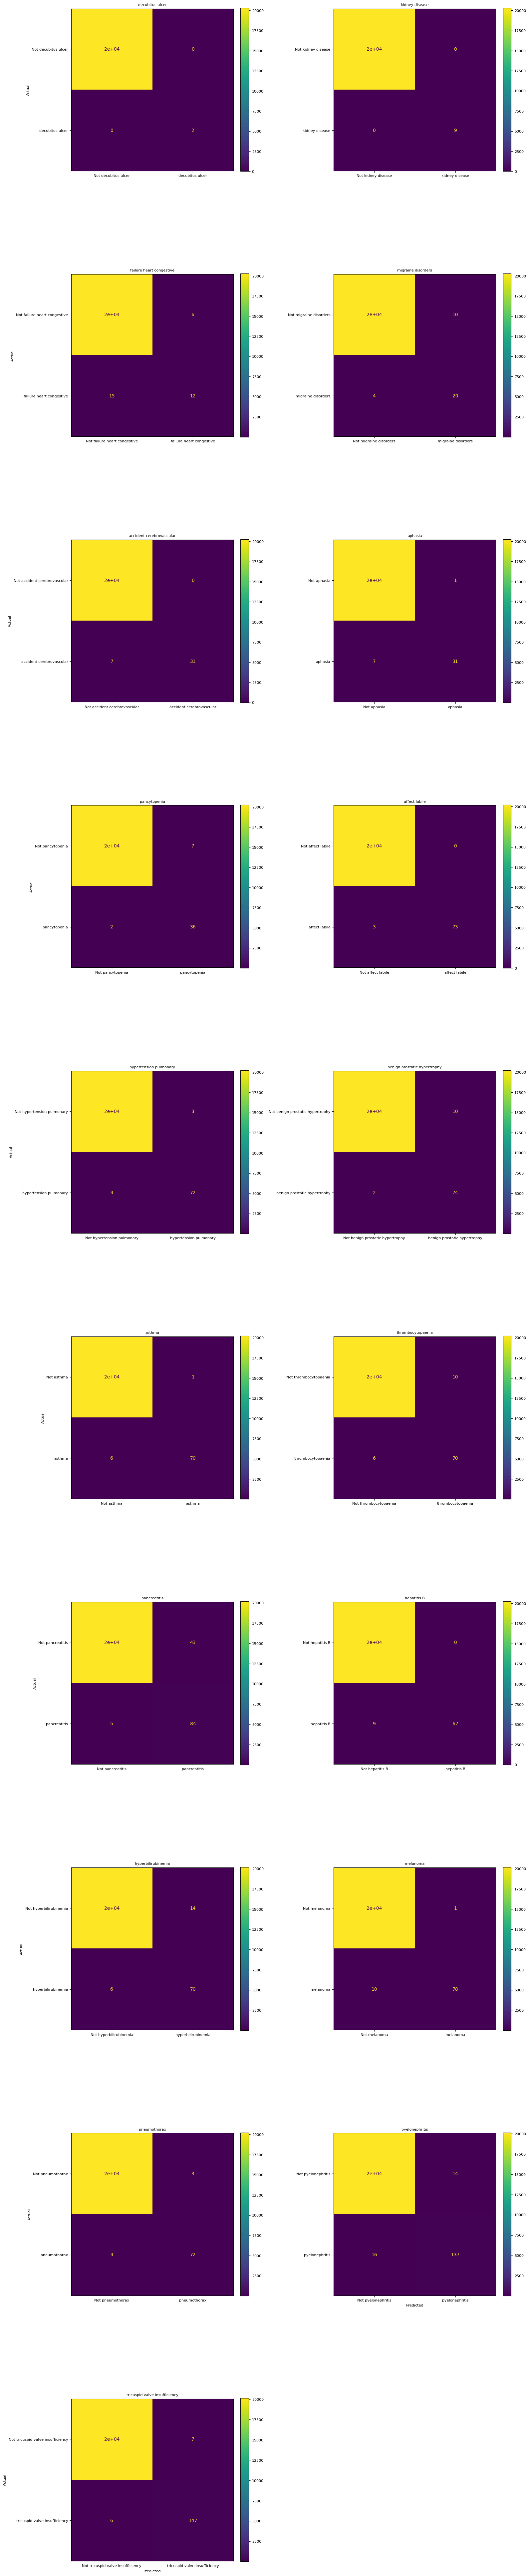

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the tail-part diseases
tail_part_diseases = [
    "decubitus ulcer", "kidney disease", "failure heart congestive", "migraine disorders", "accident cerebrovascular",
    "aphasia", "pancytopenia", "affect labile", "hypertension pulmonary", "benign prostatic hypertrophy",
    "asthma", "thrombocytopaenia", "pancreatitis", "hepatitis B", "hyperbilirubinemia",
    "melanoma", "pneumothorax", "pyelonephritis", "tricuspid valve insufficiency"
]

# Get the corresponding label indices for the tail-part diseases
tail_part_indices = [list(label_encoder.classes_).index(disease) for disease in tail_part_diseases]

# Plot settings
num_plots_per_row = 2
plot_size = (8, 8)

# Initialize plot count
plt.figure(figsize=(plot_size[0] * num_plots_per_row, plot_size[1] * ((len(tail_part_diseases) + num_plots_per_row - 1) // num_plots_per_row)))

# Loop through each disease in the tail_part_diseases list
for i, (disease, disease_idx) in enumerate(zip(tail_part_diseases, tail_part_indices)):
    # Filter test data for the current disease
    y_test_binary = (test_labels.cpu().numpy() == disease_idx).astype(int)  # 1 if the disease matches, 0 otherwise
    y_pred_binary = (test_preds == disease_idx).astype(int)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test_binary, y_pred_binary, labels=[0, 1])

    # Plot the confusion matrix
    ax = plt.subplot((len(tail_part_diseases) + num_plots_per_row - 1) // num_plots_per_row, num_plots_per_row, i + 1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not " + disease, disease])
    disp.plot(cmap='viridis', xticks_rotation='horizontal', ax=ax, colorbar=False)
    cbar = plt.colorbar(disp.im_, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)
    ax.set_title(f"{disease}", fontsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xlabel("Predicted", fontsize=8)
    ax.set_ylabel("Actual", fontsize=8)
    if i % num_plots_per_row != 0:
        ax.set_ylabel('')
    if i < len(tail_part_diseases) - num_plots_per_row:
        ax.set_xlabel('')

plt.tight_layout()
plt.show()


# Support Vector Classifier

In [21]:
# Train Support Vector Classifier (SVC) on Embeddings
from sklearn.svm import SVC

svc_model = SVC(kernel='linear', random_state=42)
svc_model.fit(train_embeddings, train_data['disease_label'])

# Validate the Model
val_preds = svc_model.predict(val_embeddings)
val_report = classification_report(val_data['disease_label'], val_preds, target_names=label_encoder.classes_, output_dict=True)
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = svc_model.predict(test_embeddings)
test_report = classification_report(test_data['disease_label'], test_preds, target_names=label_encoder.classes_, output_dict=True)
print("Test Report:")
print(pd.DataFrame(test_report))


Validation Report:
           accident cerebrovascular  affect labile    aphasia     asthma  \
precision                  0.971429            1.0   0.883721   1.000000   
recall                     0.894737            1.0   1.000000   0.960526   
f1-score                   0.931507            1.0   0.938272   0.979866   
support                   38.000000           76.0  38.000000  76.000000   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                      0.987013          0.992395          0.990148   
recall                         1.000000          0.850163          0.982085   
f1-score                       0.993464          0.915789          0.986100   
support                       76.000000        614.000000        614.000000   

           carcinoma colon  carcinoma of lung   cirrhosis  ...  pancreatitis  \
precision         0.998779           0.998574    0.972973  ...      0.391304   
recall            0.998779           0.99735

In [22]:
# Save Classification Report to CSV
test_report_df = pd.DataFrame(test_report).transpose()
test_report_path = "/content/drive/MyDrive/P2/T1.2/Dataset/LLM + ML/clinicalT5-svc-class.csv"
test_report_df.to_csv(test_report_path, index=True)
print(f"Classification report saved to {test_report_path}")

Classification report saved to /content/drive/MyDrive/P2/T1.2/Dataset/LLM + ML/clinicalT5-svc-class.csv


<Figure size 1800x800 with 0 Axes>

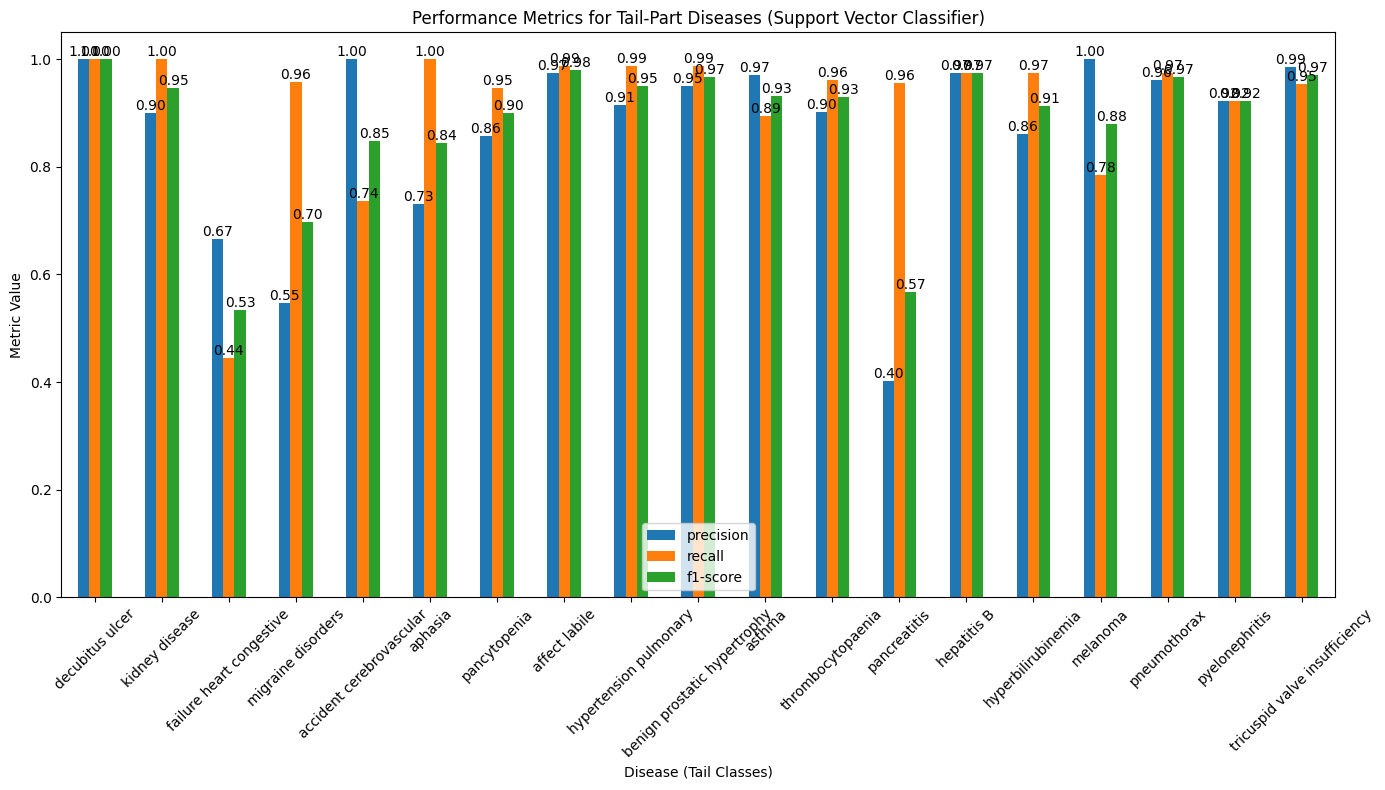

In [23]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Convert classification report to DataFrame
test_report_df = pd.DataFrame(test_report).transpose()

# Generate Classification Report for Tail-Part Diseases
tail_part_diseases = [
    "decubitus ulcer", "kidney disease", "failure heart congestive", "migraine disorders", "accident cerebrovascular",
    "aphasia", "pancytopenia", "affect labile", "hypertension pulmonary", "benign prostatic hypertrophy",
    "asthma", "thrombocytopaenia", "pancreatitis", "hepatitis B", "hyperbilirubinemia",
    "melanoma", "pneumothorax", "pyelonephritis", "tricuspid valve insufficiency"
]

# Ensure only existing diseases are considered
tail_part_diseases_present = [disease for disease in tail_part_diseases if disease in test_report_df.index]

# Extract metrics for the diseases in the tail_part_diseases list
tail_metrics = test_report_df.loc[tail_part_diseases_present, ["precision", "recall", "f1-score"]]

# Plot the metrics for tail-part diseases
plt.figure(figsize=(18, 8))
ax = tail_metrics.plot(kind='bar', figsize=(14, 8), legend=True)

# Annotate values on the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

# Add titles and labels
plt.title("Performance Metrics for Tail-Part Diseases (Support Vector Classifier)")
plt.xlabel("Disease (Tail Classes)")
plt.ylabel("Metric Value")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


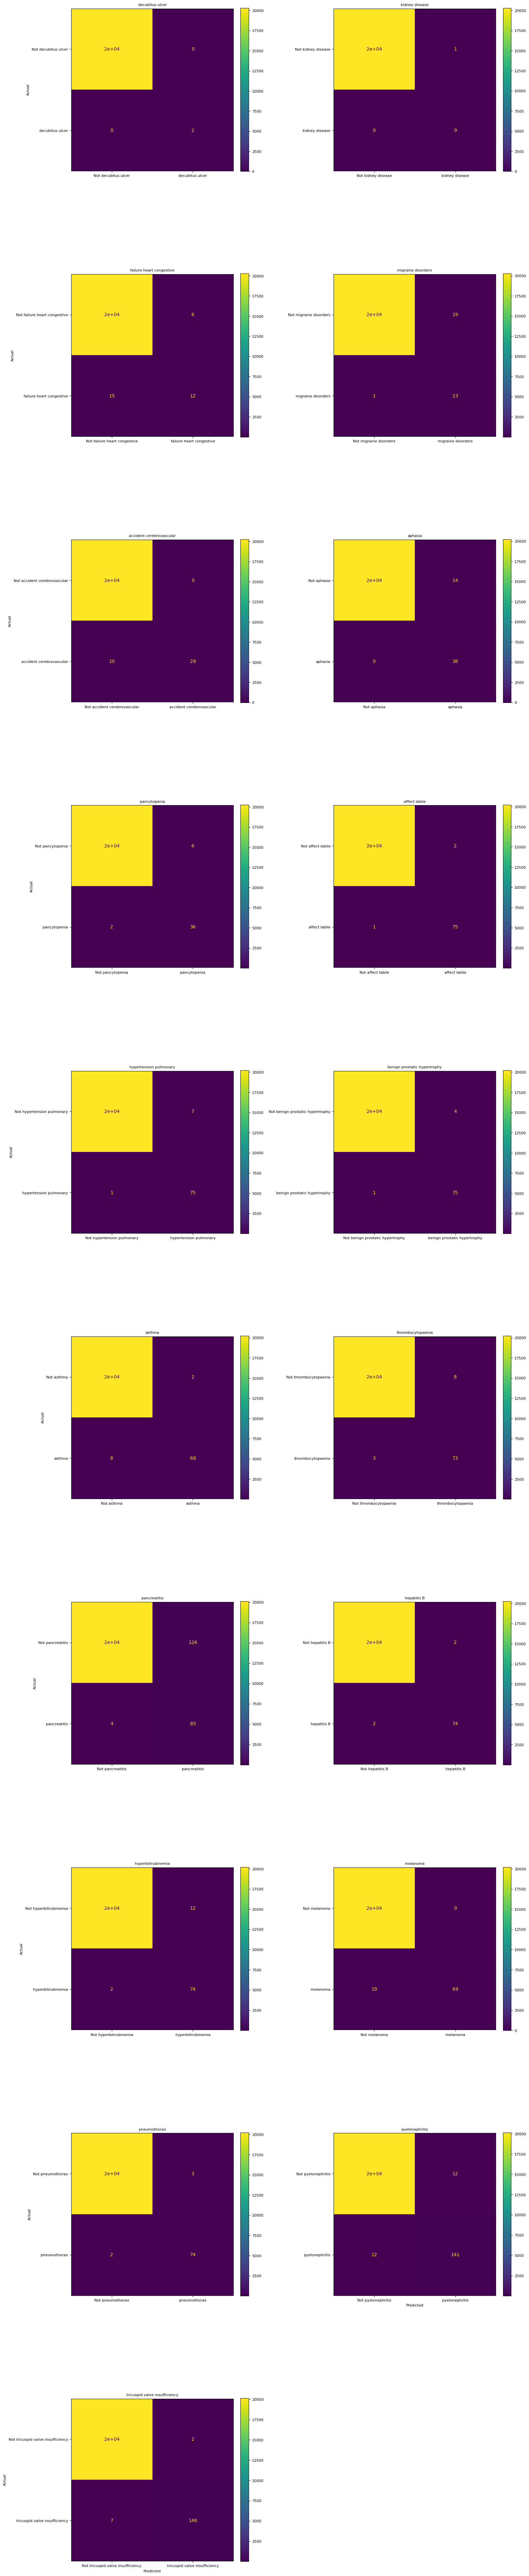

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the tail-part diseases
tail_part_diseases = [
    "decubitus ulcer", "kidney disease", "failure heart congestive", "migraine disorders", "accident cerebrovascular",
    "aphasia", "pancytopenia", "affect labile", "hypertension pulmonary", "benign prostatic hypertrophy",
    "asthma", "thrombocytopaenia", "pancreatitis", "hepatitis B", "hyperbilirubinemia",
    "melanoma", "pneumothorax", "pyelonephritis", "tricuspid valve insufficiency"
]

# Ensure only existing diseases are considered
tail_part_diseases_present = [disease for disease in tail_part_diseases if disease in label_encoder.classes_]

# Plot settings
num_plots_per_row = 2
plot_size = (8, 8)

plt.figure(figsize=(plot_size[0] * num_plots_per_row, plot_size[1] * ((len(tail_part_diseases_present) + num_plots_per_row - 1) // num_plots_per_row)))

for i, disease in enumerate(tail_part_diseases_present):
    # Get the disease index
    disease_idx = list(label_encoder.classes_).index(disease)

    # Convert test_labels to NumPy array and create binary labels
    y_test_binary = (test_labels.cpu().numpy() == disease_idx).astype(int)
    y_pred_binary = (test_preds == disease_idx).astype(int)  # Assuming test_preds is already a NumPy array

    # Compute the confusion matrix
    cm = confusion_matrix(y_test_binary, y_pred_binary, labels=[0, 1])

    # Plot the confusion matrix
    ax = plt.subplot((len(tail_part_diseases_present) + num_plots_per_row - 1) // num_plots_per_row, num_plots_per_row, i + 1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not " + disease, disease])
    disp.plot(cmap='viridis', xticks_rotation='horizontal', ax=ax, colorbar=False)
    cbar = plt.colorbar(disp.im_, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)
    ax.set_title(f"{disease}", fontsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xlabel("Predicted", fontsize=8)
    ax.set_ylabel("Actual", fontsize=8)
    if i % num_plots_per_row != 0:
        ax.set_ylabel('')
    if i < len(tail_part_diseases_present) - num_plots_per_row:
        ax.set_xlabel('')

plt.tight_layout()
plt.show()


# Head-Part Disease

<Figure size 1800x800 with 0 Axes>

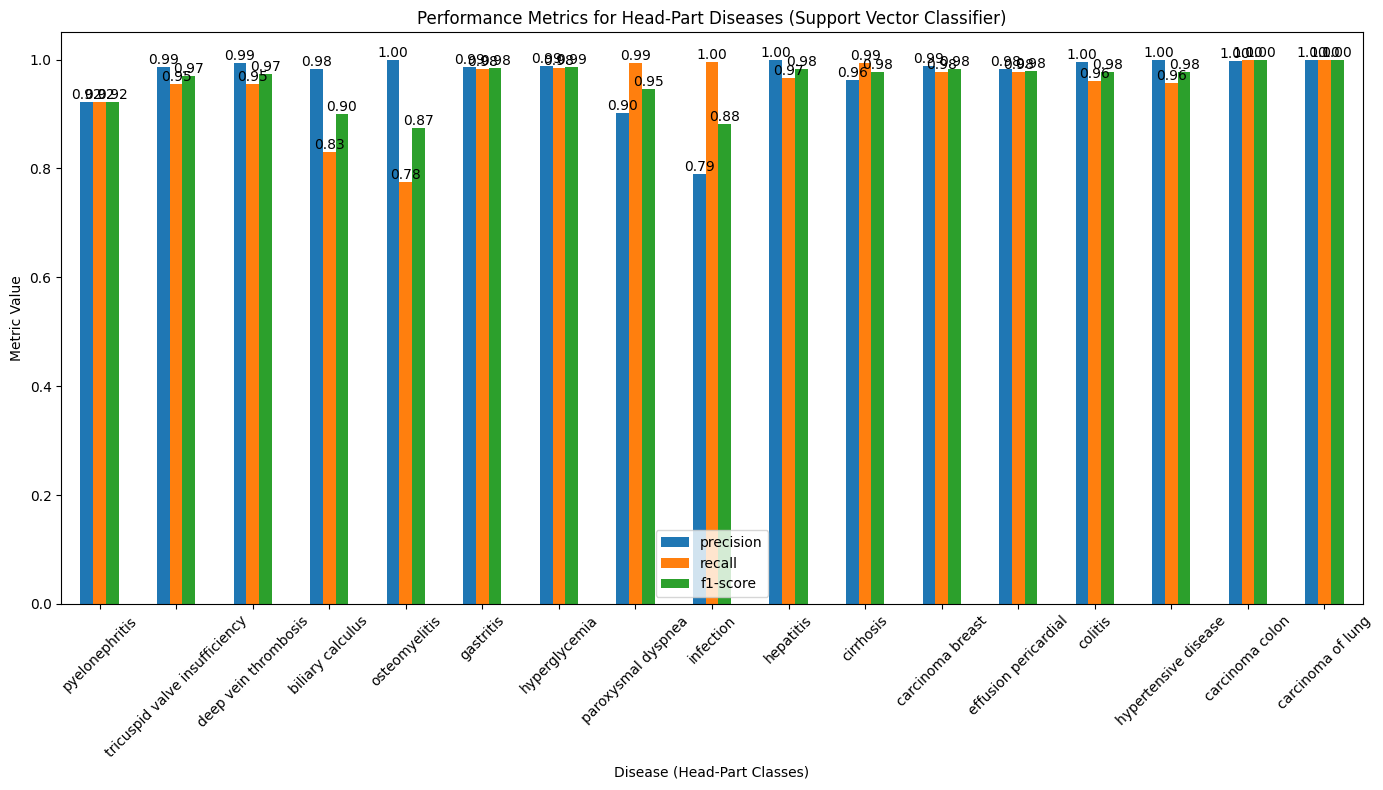

In [25]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Convert classification report to DataFrame
test_report_df = pd.DataFrame(test_report).transpose()

# Define Head-Part Diseases
head_part_diseases = [
    "pyelonephritis", "tricuspid valve insufficiency", "deep vein thrombosis", "biliary calculus", "osteomyelitis",
    "gastritis", "hyperglycemia", "paroxysmal dyspnea", "infection", "hepatitis",
    "cirrhosis", "carcinoma breast", "effusion pericardial", "colitis", "hypertensive disease",
    "carcinoma colon", "carcinoma of lung"
]

# Ensure only existing diseases are considered for head-part
head_part_diseases_present = [disease for disease in head_part_diseases if disease in test_report_df.index]

# Extract metrics for head-part diseases
head_metrics = test_report_df.loc[head_part_diseases_present, ["precision", "recall", "f1-score"]]

# Plot the metrics for head-part diseases
plt.figure(figsize=(18, 8))
ax = head_metrics.plot(kind='bar', figsize=(14, 8), legend=True)

# Annotate values on the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

# Add titles and labels
plt.title("Performance Metrics for Head-Part Diseases (Support Vector Classifier)")
plt.xlabel("Disease (Head-Part Classes)")
plt.ylabel("Metric Value")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()
